In [1]:
import pickle
import string
import warnings
import gensim 
import h5py
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import normalize

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

warnings.filterwarnings(action='ignore') 


c:\users\luke\iclouddrive\documents\graduate_school\fall_2018\ds595\venv_pc\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [117]:
# Parameterize this ish
# Length of vector for each word
max_word2vec_components = 256
# Length of subset to consider
sample_size = 30000
# Threshold for sparsifying. Values less than this will be set to 0 in similarity matrix
threshold = 0.3
# Window size for subsampling sparse similarity matrix
window_size = 20
# Compression size
comp_size = 2


{'CNN': [0.66, 0.718, 0.57], 'PCA_100+XGBoost': [0.693, 0.75, 0.565], 'PCA_50+XGBoost': [0.689, 0.748, 0.565], 'baseline': [0.6943434343434344, 0.7266907065355863, 0.6193564762837815], 'XGBoost_full100': [0.6811111111111111, 0.7329586892768103, 0.9340985078718101], 'XGBoost_full75': [0.684949494949495, 0.734875896713156, 0.9153928981275047], 'XGBoost_full50': [0.6796969696969697, 0.7239762621337456, 0.89394626000627], 'XGBoost_full25': [0.6652525252525252, 0.7003312234871989, 0.8458255921430086], 'XGBoost_full15': [0.6563636363636364, 0.680431395610271, 0.800789537622404], 'XGBoost_full10': [0.6392929292929292, 0.6627128078952527, 0.7652747155022656], 'XGBoost_full9': [0.6360606060606061, 0.647727572689595, 0.7549728959307147], 'XGBoost_full8': [0.6418181818181818, 0.6595427901014278, 0.7427937270292017], 'XGBoost_full7': [0.6421212121212121, 0.660091871881123, 0.743484776909628], 'XGBoost_full6': [0.6285858585858586, 0.6170971192872315, 0.7546221636612626], 'XGBoost_full5': [0.6277777

In [3]:
# Load the data
train_data = pd.read_csv("./Data/train.csv")
test_data_ = pd.read_csv("./Data/test.csv")


In [4]:
# Retrieve a list of the questions in the training set
train_question1s = train_data["question1"].astype(str).tolist()
train_question2s = train_data["question2"].astype(str).tolist()

# Combine the two for vectorization and dimension reduction
train_questions = train_question1s + train_question2s

translator = str.maketrans('', '', string.punctuation)
data = []

# Make each question a list of cleaned words
for q in train_questions:
    # Remove punctuation
    q = q.translate(translator)
    # Make everything lowercase
    q = q.lower()
    # Append it back to the list
    data.append(q.split(" "))


In [44]:
# Declare and train the Word2Vec model
# Note: Min_count is the minimum number of times a word needs to appear for the model to consider it.
#       If this is changed from 1, what we are doing will not work.
model = gensim.models.Word2Vec(data, size=max_word2vec_components, window=10, min_count=1, workers=25)
model.train(data, total_examples=len(data), epochs=10)


(150383994, 1916334600)

In [51]:
# Save the Word2Vec model
with open("./word2vec_model.p", "wb") as f:
    pickle.dump(model, f)


In [ ]:
# Reload the Word2Vec model
with open("./word2vec_model.p", "rb") as f:
    model = pickle.load(f)


In [259]:
# Find the max number of words in all questions 
data = data

_max = 0
idx = 0
i = 0
for q in data:
    if len(q) > _max:
        idx = i
        _max = len(q)
    i += 1


0
5
14
211
241
320
1077
1614
20875
33209
35101
408616
422345
422345


In [ ]:
# Pad every question to be the same length
for q in data:
    if len(q) < _max:
        q += ([''] * (_max - len(q)))


In [ ]:
# Separate the "tokenized" questions into original two lists
q1_data = data[:len(train_question1s)]
q2_data = data[len(train_question2s):]


In [52]:
# Compute the similarity scores between each vectorized question 
similarity_scores = []

for i in range(len(q1_data)):
    pairwise_similarity = []
    
    for j in range(_max):
        
        q1_word = model[q1_data[i][j]].reshape((1, max_word2vec_components))
        q2_sent = model[q2_data[i]]
        
        c_sim = cosine_similarity(q1_word, q2_sent, dense_output=False)
        pairwise_similarity.append(c_sim.tolist())

    similarity_scores.append(pairwise_similarity)

similarity_scores = np.array(similarity_scores)


In [ ]:
# Save the similarity scores
with h5py.File('similarity_scores.h5', 'w') as hf:
    hf.create_dataset("similarity-scores",  data=similarity_scores)


In [ ]:
# Load in the similarity scores. This can be skipped if you are running the whole way though
with h5py.File('similarity_scores.h5', 'r') as hf:
    similarity_scores = hf['similarity-scores'][:]

# Show a random image to demonstrate sparsity and where the actual data lives
sample_image = similarity_scores[np.random.randint(0, sample_size-1)]
plt.imshow(sample_image)
plt.show()


In [ ]:
# Declare dictionary to hold results
model_results = {}

model_results['CNN'] = [0.660, 0.718, 0.570]
model_results['PCA_100+XGBoost'] = [0.693, 0.750, 0.565]
model_results['PCA_50+XGBoost'] = [0.689, 0.748, 0.565]
model_results['baseline'] = [baseline_acc, baseline_roc_auc, baseline_log_loss]

print(model_results)


In [8]:
# Prepare the data to compute a baseline score
similarity_scores = similarity_scores.reshape((sample_size, 237*237))

X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(similarity_scores, train_data.loc[:sample_size-1]['is_duplicate'], test_size=0.33, random_state=42)

similarity_scores = similarity_scores.reshape((sample_size, 237, 237))

(30000, 56169)


In [9]:
baseline_model = GradientBoostingClassifier(n_estimators=500, max_features='log2', max_depth=10)
baseline_model.fit(X_train_baseline, y_train_baseline)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [10]:
y_hat_baseline = baseline_model.predict(X_test_baseline)
y_hat_proba_baseline = baseline_model.predict_proba(X_test_baseline)

baseline_acc = accuracy_score(y_test_baseline, y_hat_baseline)
baseline_roc_auc = roc_auc_score(y_test_baseline, y_hat_proba_baseline[:, 1])
baseline_log_loss = log_loss(y_test_baseline, y_hat_proba_baseline[:, 1])

print(baseline_acc)
print(baseline_roc_auc)
print(baseline_log_loss)


In [15]:
# Copy the similarity scores to a preserve the original data
#    This allows us to play with how sparse we want to make the results
sparse_results = copy.copy(similarity_scores)
sparse_results[sparse_results < threshold] = 0.0

sparse_results = sparse_results.reshape((sample_size, 237, 237))

In [118]:
# Since the majority of our data lives in the upper-left quadrant
#    Let's readjust the size to speed things up
sub_sparse = sparse_results[:, :window_size, :window_size]

# Make a random matrix to compress our data
A = np.random.normal(loc=0, scale=1, size=(comp_size, window_size*window_size))

comp_sub_sparse_data = []

for i in range(sub_sparse.shape[0]):
    # Bang every entry in our sub-sampled sparse dataset into this vector
    comp_vec = np.matmul(A, sub_sparse[i].reshape(window_size*window_size, 1))
    comp_sub_sparse_data.append(comp_vec)
    
# Convert this new data into a numpy array for convenience 
comp_sub_sparse_data = np.array(comp_sub_sparse_data)
comp_sub_sparse_data = comp_sub_sparse_data.reshape((comp_sub_sparse_data.shape[0], comp_sub_sparse_data.shape[1]))
print(comp_sub_sparse_data.shape)


(30000, 2)


In [101]:
# Because we only used the first 30,000 questions get their labels
labels = train_data.loc[:sample_size-1]['is_duplicate']


In [102]:
X_train, X_test, y_train, y_test = train_test_split(comp_sub_sparse_data, labels, test_size=0.33, random_state=42)


In [103]:
# Build a generic XGBoost classifier
xgb_classifier_full = GradientBoostingClassifier(n_estimators=500, max_features='log2', max_depth=10)
xgb_classifier_full.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [104]:
# Score it and save the results
y_hat_proba_xgb = xgb_classifier_full.predict_proba(X_test)
y_hat_xgb = xgb_classifier_full.predict(X_test)

xgb_acc = accuracy_score(y_test, y_hat_xgb)
xgb_roc_auc = roc_auc_score(y_test, y_hat_proba_xgb[:, 1])
xgb_log_loss = log_loss(y_test, y_hat_proba_xgb[:, 1])

model_results[('XGBoost_full' + str(comp_size))] = [xgb_acc, xgb_roc_auc, xgb_log_loss]

print(xgb_acc)
print(xgb_roc_auc)
print(xgb_log_loss)


0.5719191919191919
0.5090319922983171
0.7310596280401725


In [230]:
# Build a generic Random Forest Classifier
rf_classifier_full = RandomForestClassifier(n_estimators=500, max_depth=10, max_features='sqrt', n_jobs=-1)
rf_classifier_full.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [232]:
# Score it and save the results
y_hat_proba_rf = rf_classifier_full.predict_proba(X_test)
y_hat_rf = rf_classifier_full.predict(X_test)

rf_acc = accuracy_score(y_test, y_hat_rf)
rf_roc_auc = roc_auc_score(y_test, y_hat_proba_rf[:, 1])
rf_log_loss = log_loss(y_test, y_hat_proba_rf[:, 1])

model_results['RandomForest_full'] = [rf_acc, rf_roc_auc, rf_log_loss]

print(rf_acc)
print(rf_roc_auc)
print(rf_log_loss)


0.6731313131313131
0.7398514521097166
11.289708777119738


In [233]:
# Build a generic QDA model
qda_classifier_full = QuadraticDiscriminantAnalysis()
qda_classifier_full.fit(X_train, y_train)


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [234]:
# Score it and save the results
y_hat_proba_qda = qda_classifier_full.predict_proba(X_test)
y_hat_qda = qda_classifier_full.predict(X_test)

qda_acc = accuracy_score(y_test, y_hat_qda)
qda_roc_auc = roc_auc_score(y_test, y_hat_proba_qda[:, 1])
qda_log_loss = log_loss(y_test, y_hat_proba_qda[:, 1])

model_results['QDA_full'] = [qda_acc, qda_roc_auc, qda_log_loss]

print(qda_acc)
print(qda_roc_auc)
print(qda_log_loss)


0.5667676767676768
0.6845759605439403
14.963593552130112


With L2 Normalization


In [235]:
# Let's try with some normalized data
# Normalize the Data with L2
X_train_l2 = normalize(X_train, norm='l2')
X_test_l2 = normalize(X_test, norm='l2')


In [236]:
# Let's try the same XGBoost model from above with the L2-normed data
xgb_classifier_l2 = GradientBoostingClassifier(n_estimators=500, max_features='log2', max_depth=10)
xgb_classifier_l2.fit(X_train_l2, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [238]:
# Score it and save the results
y_hat_proba_xgb_l2 = xgb_classifier_l2.predict_proba(X_test_l2)
y_hat_xgb_l2 = xgb_classifier_l2.predict(X_test_l2)

xgb_acc_l2 = accuracy_score(y_test, y_hat_xgb_l2)
xgb_roc_auc_l2 = roc_auc_score(y_test, y_hat_proba_xgb_l2[:, 1])
xgb_log_loss_l2 = log_loss(y_test, y_hat_proba_xgb_l2[:, 1])

model_results['XGBoost_l2'] = [xgb_acc_l2, xgb_roc_auc_l2, xgb_log_loss_l2]

print(xgb_acc_l2)
print(xgb_roc_auc_l2)
print(xgb_log_loss_l2)


0.6864646464646464
0.7444946332817566
10.82920548898185


In [239]:
# Normalize the Data with L1
X_train_l1 = normalize(X_train, norm='l1')
X_test_l1 = normalize(X_test, norm='l1')


In [240]:
# Let's try the same XGBoost model from above with the L1-normed data
xgb_classifier_l1 = GradientBoostingClassifier(n_estimators=500, max_features='log2', max_depth=10)
xgb_classifier_l1.fit(X_train_l1, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [242]:
# Score it and save the results
y_hat_proba_xgb_l1 = xgb_classifier_l1.predict_proba(X_test_l1)
y_hat_xgb_l1 = xgb_classifier_l1.predict(X_test_l1)

xgb_acc_l1 = accuracy_score(y_test, y_hat_xgb_l1)
xgb_roc_auc_l1 = roc_auc_score(y_test, y_hat_proba_xgb_l1[:, 1])
xgb_log_loss_l1 = log_loss(y_test, y_hat_proba_xgb_l1[:, 1])

model_results['XGBoost_l1'] = [xgb_acc_l1, xgb_roc_auc_l1, xgb_log_loss_l1]

print(xgb_acc_l1)
print(xgb_roc_auc_l1)
print(xgb_log_loss_l1)


0.6846464646464646
0.7383700754536705
10.892004314221747


In [243]:
# Normalize the Data with MAX
X_train_max = normalize(X_train, norm='max')
X_test_max = normalize(X_test, norm='max')


In [244]:
# Let's try the same XGBoost model from above with the MAX-normed data
xgb_classifier_max = GradientBoostingClassifier(n_estimators=500, max_features='log2', max_depth=10)
xgb_classifier_max.fit(X_train_max, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
# Score it and save the results
y_hat_proba_xgb_max = xgb_classifier_max.predict_proba(X_test_max)
y_hat_xgb_max = xgb_classifier_max.predict(X_test_max)

xgb_acc_max = accuracy_score(y_test, y_hat_xgb_max)
xgb_roc_auc_max = roc_auc_score(y_test, y_hat_proba_xgb_max[:, 1])
xgb_log_loss_max = log_loss(y_test, y_hat_proba_xgb_max[:, 1])

model_results['XGBoost_max'] = [xgb_acc_max, xgb_roc_auc_max, xgb_log_loss_max]

print(xgb_acc_max)
print(xgb_roc_auc_max)
print(xgb_log_loss_max)


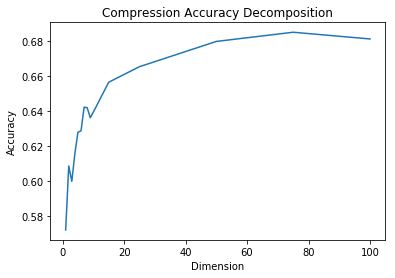

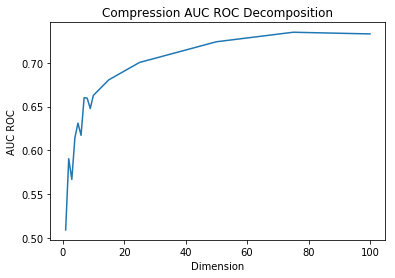

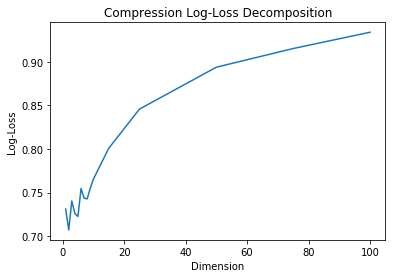

In [120]:
# Plot the decomposition of random compression
comp_dims = []
comp_accs = []
comp_aucs = []
comp_llss = []

for k in model_results.keys():
    if "XGBoost_full" in k:
        comp_dims.append(int(k.split('ll')[1]))
        comp_accs.append(model_results[k][0])
        comp_aucs.append(model_results[k][1])
        comp_llss.append(model_results[k][2])

plt.plot(comp_dims, comp_accs)
plt.title("Compression Accuracy Decomposition")
plt.xlabel("Dimension")
plt.ylabel("Accuracy")
plt.savefig('./CompressionAccuracies.png', dpi=700)
plt.show()
plt.close()

plt.plot(comp_dims, comp_aucs)
plt.title("Compression AUC ROC Decomposition")
plt.xlabel("Dimension")
plt.ylabel("AUC ROC")
plt.savefig('./CompressionAUCs.png', dpi=700)
plt.show()
plt.close()

plt.plot(comp_dims, comp_llss)
plt.title("Compression Log-Loss Decomposition")
plt.xlabel("Dimension")
plt.ylabel("Log-Loss")
plt.savefig('./CompressionLLS.png', dpi=700)
plt.show()
plt.close()

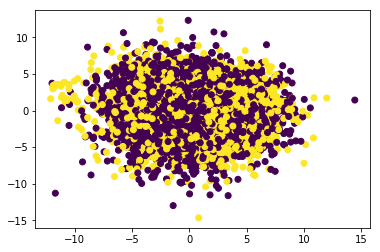

In [119]:
# Plot the data when compressed to 2 dimensions
plt.scatter(comp_sub_sparse_data[:, 0], comp_sub_sparse_data[:, 1], c=labels)

In [247]:
# Retrieve the metrics from the dictionary
accs = []
aucs = []
llss = []

for mod in model_results.keys():
    accs.append(model_results[mod][0])
    aucs.append(model_results[mod][1])
    llss.append(model_results[mod][2])


In [248]:
# Plot the accuracies
plt.bar(model_results.keys(), accs)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./Accuracies.png', dpi=700)
plt.show()
plt.close()


In [250]:
# Plot the AUC-ROC's
plt.bar(model_results.keys(), aucs)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./ROC_AUC.png', dpi=700)
plt.show()
plt.close()


In [ ]:
# Plot the Log-loss since the Kaggle competition used it.
plt.bar(model_results.keys(), llss)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./Log_Loss.png', dpi=700)
plt.show()
plt.close()
